In [1]:
# # Uncomment the following lines if running for the first time:
# Core Required Libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install scipy
!pip install tabulate

# Model Training & Optimization
!pip install mlflow
!pip install optuna

# Data Source
!pip install datasets

# Model Conversion & Inference (ONNX + Hummingbird)
!pip install skl2onnx
!pip install onnxruntime==1.21.1



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# ================================
# Standard Library Imports
# ================================
import os
import time
import pickle
import warnings
from typing import Tuple

# ================================
# Third-party Library Imports
# ================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import optuna
import mlflow
from scipy.stats import skew
from tabulate import tabulate
from datasets import load_dataset
from itertools import combinations

# ================================
# ONNX and Model Conversion
# ================================
import onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# ================================
# scikit-learn Imports
# ================================
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.inspection import DecisionBoundaryDisplay


c:\ChenKhoon\JupyterNotebook\edge-telemetry-anomaly-detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Observations
- The ONNX model is ~3.7× larger in size but provides a **~24× faster inference time** compared to the native `IsolationForest` implementation.
- This highlights ONNX Runtime's efficiency, especially for deployment scenarios requiring high-throughput or real-time inference.
- The ONNX model was derived from a supervised proxy (`RandomForestClassifier`) trained on labels generated by `IsolationForest`, enabling compatibility with ONNX while preserving anomaly detection logic.

In [3]:
data_path="../data/intel_cpu_dataset.csv"
isolation_model_path  = "../model/isolation_forest_optimized.pkl"
random_forest_path = "../model/RandomForestClassifier.pkl"
onnx_model_path = "../model/rf_anomaly_detector.onnx"

# Objective 1: Select a telemetry dataset with anomalies or failure events

In [4]:
# Automatically download and save the dataset as CSV 
# only if "intel_cpu_dataset.csv" does not already exist.
# This avoids redundant downloads and ensures reproducibility.
# Ensure the data folder exists
os.makedirs(os.path.dirname(data_path), exist_ok=True)

# Download the dataset only if it doesn't already exist
if not os.path.exists(data_path):
    print("Downloading Intel CPU dataset...")
    try:
        dataset = load_dataset("MounikaV/intel-cpu-dataset")
        dataset["train"].to_pandas().to_csv(data_path, index=False)
        print(f"Dataset saved to {data_path}")
    except Exception as e:
        print(f"Failed to load or save dataset: {e}")
else:
    print(f"Dataset already exists at {data_path}")

Dataset already exists at ../data/intel_cpu_dataset.csv


# Objective 2: Perform EDA to understand normal vs abnormal behavior

In [5]:
# Load the Intel CPU dataset from CSV
df = pd.read_csv(data_path)

# Print the shape of the dataset (rows, columns)
print(df.shape)

# Print the list of column names
print(df.columns) 

(2081, 12)
Index(['vm_id', 'timestamp', 'cpu_usage', 'memory_usage', 'network_traffic',
       'power_consumption', 'num_executed_instructions', 'execution_time',
       'energy_efficiency', 'task_type', 'task_priority', 'task_status'],
      dtype='object')


### Observation
- From the above we know that:
  - There are 12 columns (vm_id timestamp cpu_usage memory_usage network_traffic power_consumption num_executed_instructions execution_time energy_efficiency task_type task_priority task_status) 
  - There are 2081 rows

In [6]:
# Preview the first 5 rows of the dataset
df.head(10)

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,1/25/2023 9:10,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,1/26/2023 4:46,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,1/13/2023 23:39,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2/9/2023 11:45,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,6/14/2023 8:27,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting
5,ad14d5d1-4e96-48ca-9893-1baaa47e4cab,2/6/2023 16:44,64.589411,62.008016,580.569836,115.931610,4766.0,63.137671,NaN,io,low,completed
6,5651505d-14a2-41d6-989b-eec0aac9b922,6/15/2023 18:04,43.758721,22.456429,429.139640,272.960417,9008.0,60.153904,0.461246,compute,high,completed
7,e5970e5c-0350-4131-bd6c-4bd7e2c98df1,NaN,NaN,85.438155,685.282813,NaN,NaN,14.191356,0.242538,network,high,running
8,7fc95f4c-f561-4dd5-8465-aec2b388bd5b,5/20/2023 19:09,96.366276,4.388441,902.827717,367.979056,9984.0,21.876694,NaN,io,medium,running
9,7fd9a664-1da8-4ae9-8a04-3c341d32d35c,7/10/2023 11:32,38.344152,16.441881,779.791345,382.756696,2989.0,42.160847,0.139187,io,medium,running


### Observation
- From the above we know that 
  - There are some missing data in some columns. Further action needed to be taken
  - Although most of the features are numeric, there are some columns (task_type,	task_priority,	task_status) are non-numeric.
  - Based on the `task_type` column, which contains categorical values such as `network`, `io`, and `compute`, I classify this feature as nominal since the categories represent distinct types without any inherent order.
  - The `task_priority` column contains categorical values such as `high`, `medium`, and `low`, which have a clear inherent order. Therefore, I classify this feature as ordinal.
  - Similarly, the `task_status` column includes categorical values like `waiting`, `running`, and `completed`, which suggest a natural progression. Hence, I classify this feature as ordinal.


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   vm_id                      1865 non-null   object 
 1   timestamp                  1886 non-null   object 
 2   cpu_usage                  1877 non-null   float64
 3   memory_usage               1865 non-null   float64
 4   network_traffic            1862 non-null   float64
 5   power_consumption          1872 non-null   float64
 6   num_executed_instructions  1872 non-null   float64
 7   execution_time             1856 non-null   float64
 8   energy_efficiency          1881 non-null   float64
 9   task_type                  1895 non-null   object 
 10  task_priority              1857 non-null   object 
 11  task_status                1856 non-null   object 
dtypes: float64(7), object(5)
memory usage: 195.2+ KB
None


### Observation
- From the above we know that:
  - There are missing values in multiple columns. We need to know the percentages of each column so we we know what action to take for each missing column.
  - There are 7  numeric columns. They are cpu_usage, memory_usage, network_traffic, power_consumption, num_executed_instructions, execution_time, energy_efficiency.
  - There are 5 non-numeric columns and they are vm_id, timestamp, task_type, task_priority, task_status.
  - There is no target column and therefore Unsupervised learning is the appropriate approach.
  - Some unsupervised model to consider may be:
    - Isolation Forest
    - Autoencoder
    - Clustering-based methods
    - Statistical outlier detection

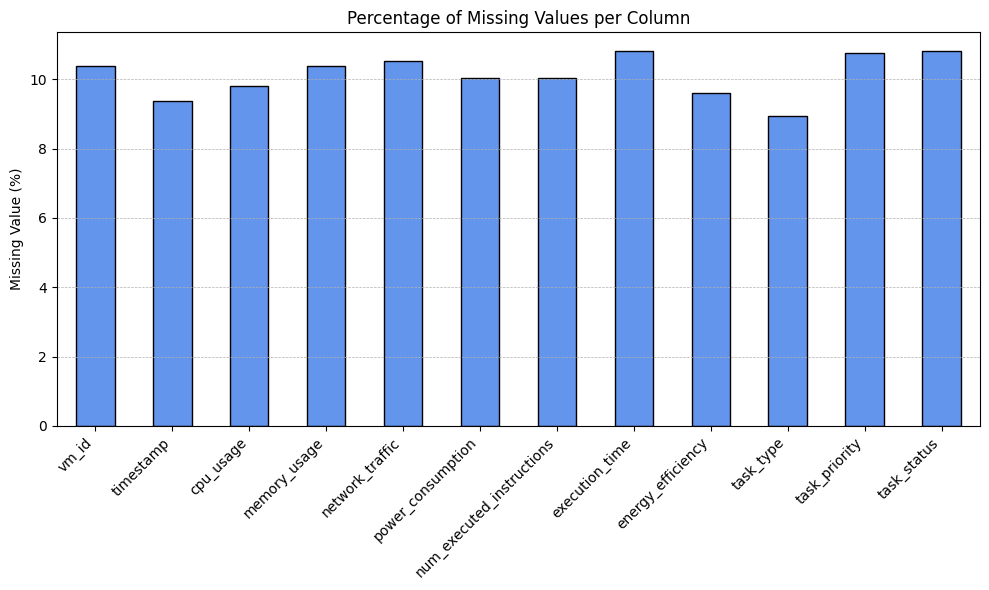

In [8]:
# Calculate percentage of missing values
missing_percent = df.isnull().mean() * 100

# Plot missing percentages
plt.figure(figsize=(10, 6))
missing_percent.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title("Percentage of Missing Values per Column")
plt.ylabel("Missing Value (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [9]:
# Total number of rows
total_rows = len(df)

# Rows with at least one missing value
rows_with_missing = df.isnull().any(axis=1).sum()

# Print results
print(f"Total rows: {total_rows}")
print(f"Rows with at least one missing value: {rows_with_missing}")
print(f"Percentage with missing: {rows_with_missing / total_rows * 100:.2f}%")

Total rows: 2081
Rows with at least one missing value: 1492
Percentage with missing: 71.70%


### Observation
- From the above we know that:
  - There are about 10% of data on each column which we need to take further action on.
  - There are about 70% of the rows has at least one missing data. We cannot drop rows with missing data as it will have sigificant impact to data. We can consider Imputation (e.g., mean/median for numeric, mode or "unknown" for categorical) is a more suitable approach to handle the missing values.
  - Given:
    - Total rows: 2081
    - Rows with at least one missing value: 1492
    - Percentage of affected rows: 71.70%
    - Missing values per column: ~9–11%
  - We should <b>impute with median</b> because:
    - Unsupervised learning requires complete feature vectors
    - Dropping rows isn't viable given that removing 71% of the dataset would result in severe data loss, undermining model generalizability.
    - Median is robust as compared to mean. The median is less sensitive to outliers and is a good choice for skewed or noisy telemetry features.
    - Preserves data size and distribution. Median imputation will retain most of the statistical properties and help preserve the distributions needed for anomaly detection.    

In [10]:
# Display summary statistics for numeric columns in GitHub-style markdown table
print(tabulate(df.describe(), headers='keys', tablefmt='github'))



|       |    cpu_usage |   memory_usage |   network_traffic |   power_consumption |   num_executed_instructions |   execution_time |   energy_efficiency |
|-------|--------------|----------------|-------------------|---------------------|-----------------------------|------------------|---------------------|
| count | 1877         |   1865         |        1862       |         1872        |                     1872    |    1856          |      1881           |
| mean  |   49.9611    |     49.4523    |         499.821   |          253.896    |                     4979.15 |      50.0836     |         0.5031      |
| std   |   29.3547    |     28.7676    |         285.983   |          142.82     |                     2892.39 |      28.4337     |         0.295109    |
| min   |    0.0367344 |      0.0230147 |           1.12517 |            0.170493 |                        3    |       0.00265404 |         0.000329933 |
| 25%   |   24.942     |     24.7701    |         253.167   |         

### Observation
- From the above we know that 
  - Balanced Mean and Median (50% Quantile)
    - For all features, the mean and median (50%) are very close, e.g.:
      - cpu_usage: mean ≈ 49.96, median ≈ 48.97
      - energy_efficiency: mean ≈ 0.5031, median ≈ 0.5047<br>
    - This indicates symmetric or near-normal distributions, which aligns with earlier histograms and low skew values.
  - Wide Range of Values
    - Each metric spans a large range, e.g.:
      - cpu_usage: from ~0 to ~100
      - network_traffic: from ~1 to ~999
      - num_executed_instructions: from 3 to 9999
    - This shows rich variance, useful for distinguishing patterns in unsupervised models.
  - Presence of Low Minimum Values
    - Many features have extremely small minimum values, e.g.:
      - execution_time: min ≈ 0.0027
      - num_executed_instructions: min = 3
    - These may represent edge cases or low-load periods — important for anomaly detection.
  - Consistent Spread Across Features
    - Standard deviations are roughly 30%–60% of the mean, suggesting healthy dispersion without extreme variability.

### Conclusion
  - The data is well-behaved and statistically balanced, with no apparent need for transformation.
  - These properties make it highly suitable for models like Isolation Forest, which perform better when features are evenly distributed and not overly skewed.
  - Outlier or anomaly detection is feasible due to wide ranges and natural variance in all metrics.

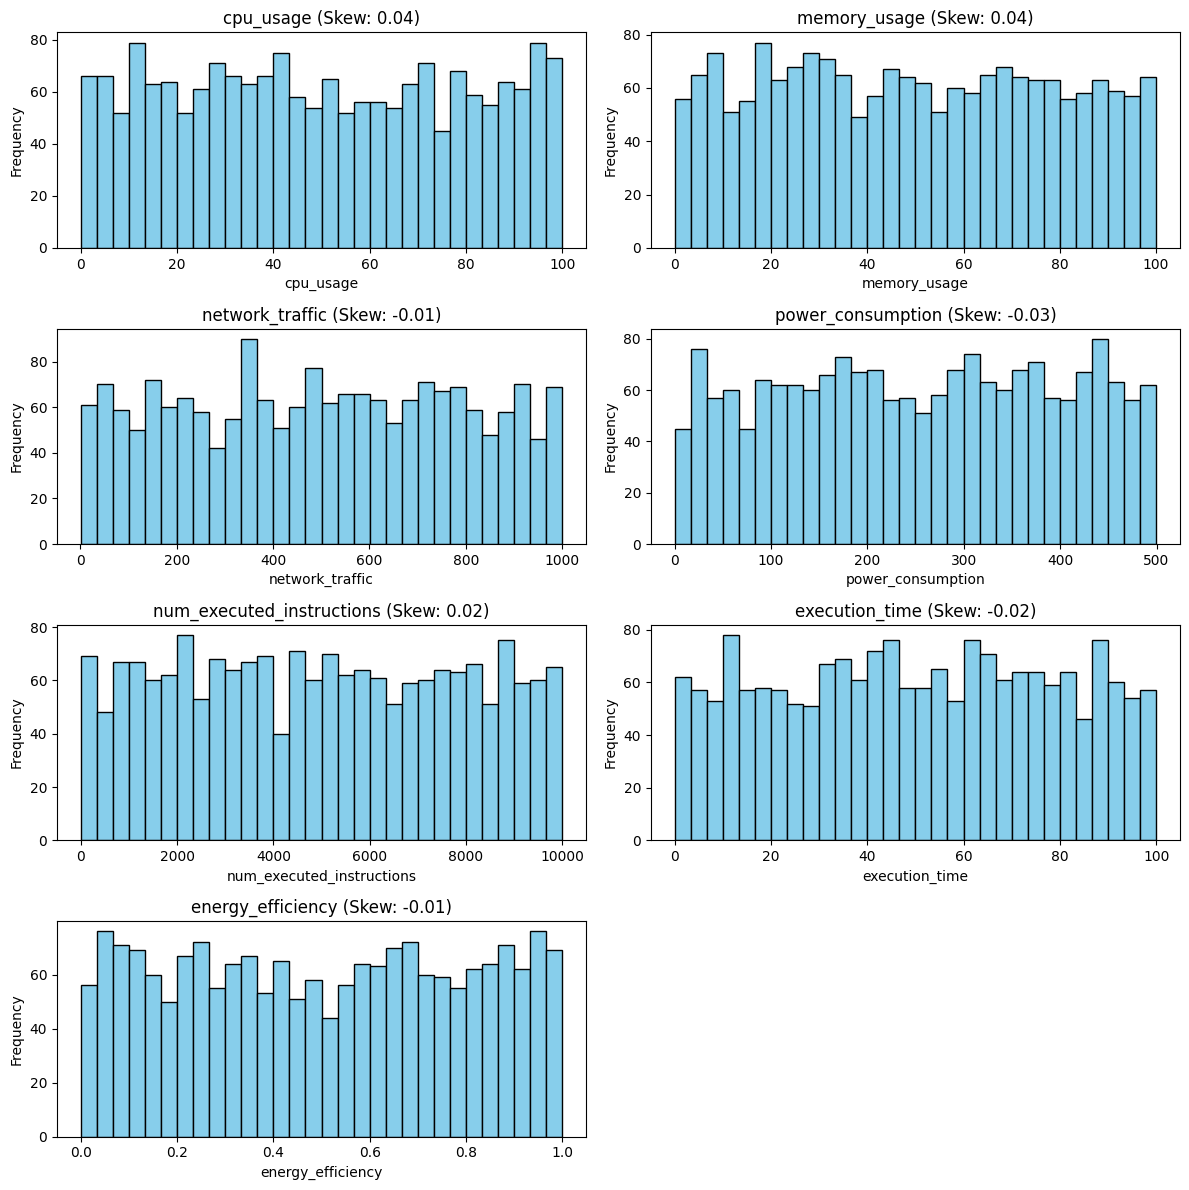

In [11]:
# Define telemetry features to visualize their distributions
# List of numeric columns to plot
continuous_features = [
    "cpu_usage", "memory_usage", "network_traffic", "power_consumption",
    "num_executed_instructions", "execution_time", "energy_efficiency"
]
# Create 4x2 subplots (7 plots + 1 unused)
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()

# Plot histograms with skewness
for i, col in enumerate(continuous_features):
    data = df[col].dropna()
    skew_val = skew(data)

    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f"{col} (Skew: {skew_val:.2f})")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Hide the last unused subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### Observation
- All Distributions Are Nearly Symmetric
  - Each numeric feature (e.g., cpu_usage, network_traffic, energy_efficiency) has a skew value close to 0 (between -0.03 and 0.02).
  - This indicates the distributions are approximately uniform or symmetric, with no major bias toward left or right tails.
- No Transformation Required
  - Due to near-zero skew, log, square root, or Box-Cox transformations are not necessary.
  - This saves preprocessing effort and helps maintain interpretability.
- Flat and Evenly Spread Distributions
  - Most histograms show a wide and flat spread, which is ideal for unsupervised anomaly detection models like Isolation Forest, which rely on feature variance.

### Conclusion
- The numeric telemetry features are statistically healthy and well-distributed, making them model-ready without significant preprocessing. Their uniform nature enhances the effectiveness of unsupervised models in detecting anomalies or irregularities.


Based on the above analysis of distributions and skewness:
- Numeric columns will be imputed using the median, as they are symmetrically distributed and the median is robust to outliers.
- Non-numeric (categorical) columns will be imputed with the placeholder 'unknown' to preserve the row and allow downstream encoding without introducing bias.
- `task_type`, `task_priority`, and `task_status` are true categorical features with a small set of discrete values.
- `vm_id` is likely an identifier and therefore not a meaningful category. To be dropped.
- `timestamp` is a datetime-like feature,

In [12]:
df.head()

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,1/25/2023 9:10,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,1/26/2023 4:46,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,1/13/2023 23:39,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2/9/2023 11:45,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,6/14/2023 8:27,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting


In [13]:
# Imputation of missing value of numeric column with median
for col in continuous_features:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# vm_id dropped
if "vm_id" in df.columns:
    df.drop(columns=["vm_id"], inplace=True)

# Encode the ordinal 'task_priority' column with numerical values:
# 'low' → 1, 'medium' → 2, 'high' → 3
# Missing or unrecognized values are filled with 0
priority_map = {"low": 1, "medium": 2, "high": 3}
df["task_priority_encoded"] = df["task_priority"].map(priority_map).fillna(0)

# task_priority dropped
if "task_priority" in df.columns:
    df.drop(columns=["task_priority"], inplace=True)

# Encode the ordinal 'task_status' column with numerical values:
# 'waiting' → 1, 'running' → 2, 'completed' → 3
# Fill missing or unrecognized entries with 0
status_map = {"waiting": 1, "running": 2, "completed": 3}
df["task_status_encoded"] = df["task_status"].map(status_map).fillna(0)

# task_status dropped
if "task_status" in df.columns:
    df.drop(columns=["task_status"], inplace=True)

# Perform one-hot encoding on the nominal 'task_type' column.
# Each unique task type (e.g., 'io', 'compute', 'network') becomes its own binary column.
# `dummy_na=True` adds a separate column to indicate missing values.
df = pd.get_dummies(df, columns=["task_type"], dummy_na=True)

# task_type dropped
if "task_type" in df.columns:
    df.drop(columns=["task_type"], inplace=True)

# Remove rows with missing timestamps to ensure valid datetime feature extraction
df = df[df["timestamp"].notna()].copy()

# Change timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

## Feature Engineering

In [14]:
# Extract datetime components into new columns
df["day"] = df["timestamp"].dt.day
df["month"] = df["timestamp"].dt.month
df["year"] = df["timestamp"].dt.year
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek  # 0 = Monday, 6 = Sunday

In [15]:
# Verification of column and data type after imputation and encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1886 entries, 0 to 2080
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   timestamp                  1886 non-null   datetime64[ns]
 1   cpu_usage                  1886 non-null   float64       
 2   memory_usage               1886 non-null   float64       
 3   network_traffic            1886 non-null   float64       
 4   power_consumption          1886 non-null   float64       
 5   num_executed_instructions  1886 non-null   float64       
 6   execution_time             1886 non-null   float64       
 7   energy_efficiency          1886 non-null   float64       
 8   task_priority_encoded      1886 non-null   float64       
 9   task_status_encoded        1886 non-null   float64       
 10  task_type_compute          1886 non-null   bool          
 11  task_type_io               1886 non-null   bool          
 12  task_type_n

In [16]:
# Check where timestamp is null
null_timestamp_df = df[df["timestamp"].isna()]

# Display some rows
print(null_timestamp_df.head())

# Optional: count how many rows have null timestamp
print(f"Number of rows with null timestamp: {null_timestamp_df.shape[0]}")

Empty DataFrame
Columns: [timestamp, cpu_usage, memory_usage, network_traffic, power_consumption, num_executed_instructions, execution_time, energy_efficiency, task_priority_encoded, task_status_encoded, task_type_compute, task_type_io, task_type_network, task_type_nan, day, month, year, hour, day_of_week]
Index: []
Number of rows with null timestamp: 0


### Observation
- All columns are numeric and ready for further analysis

In [17]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

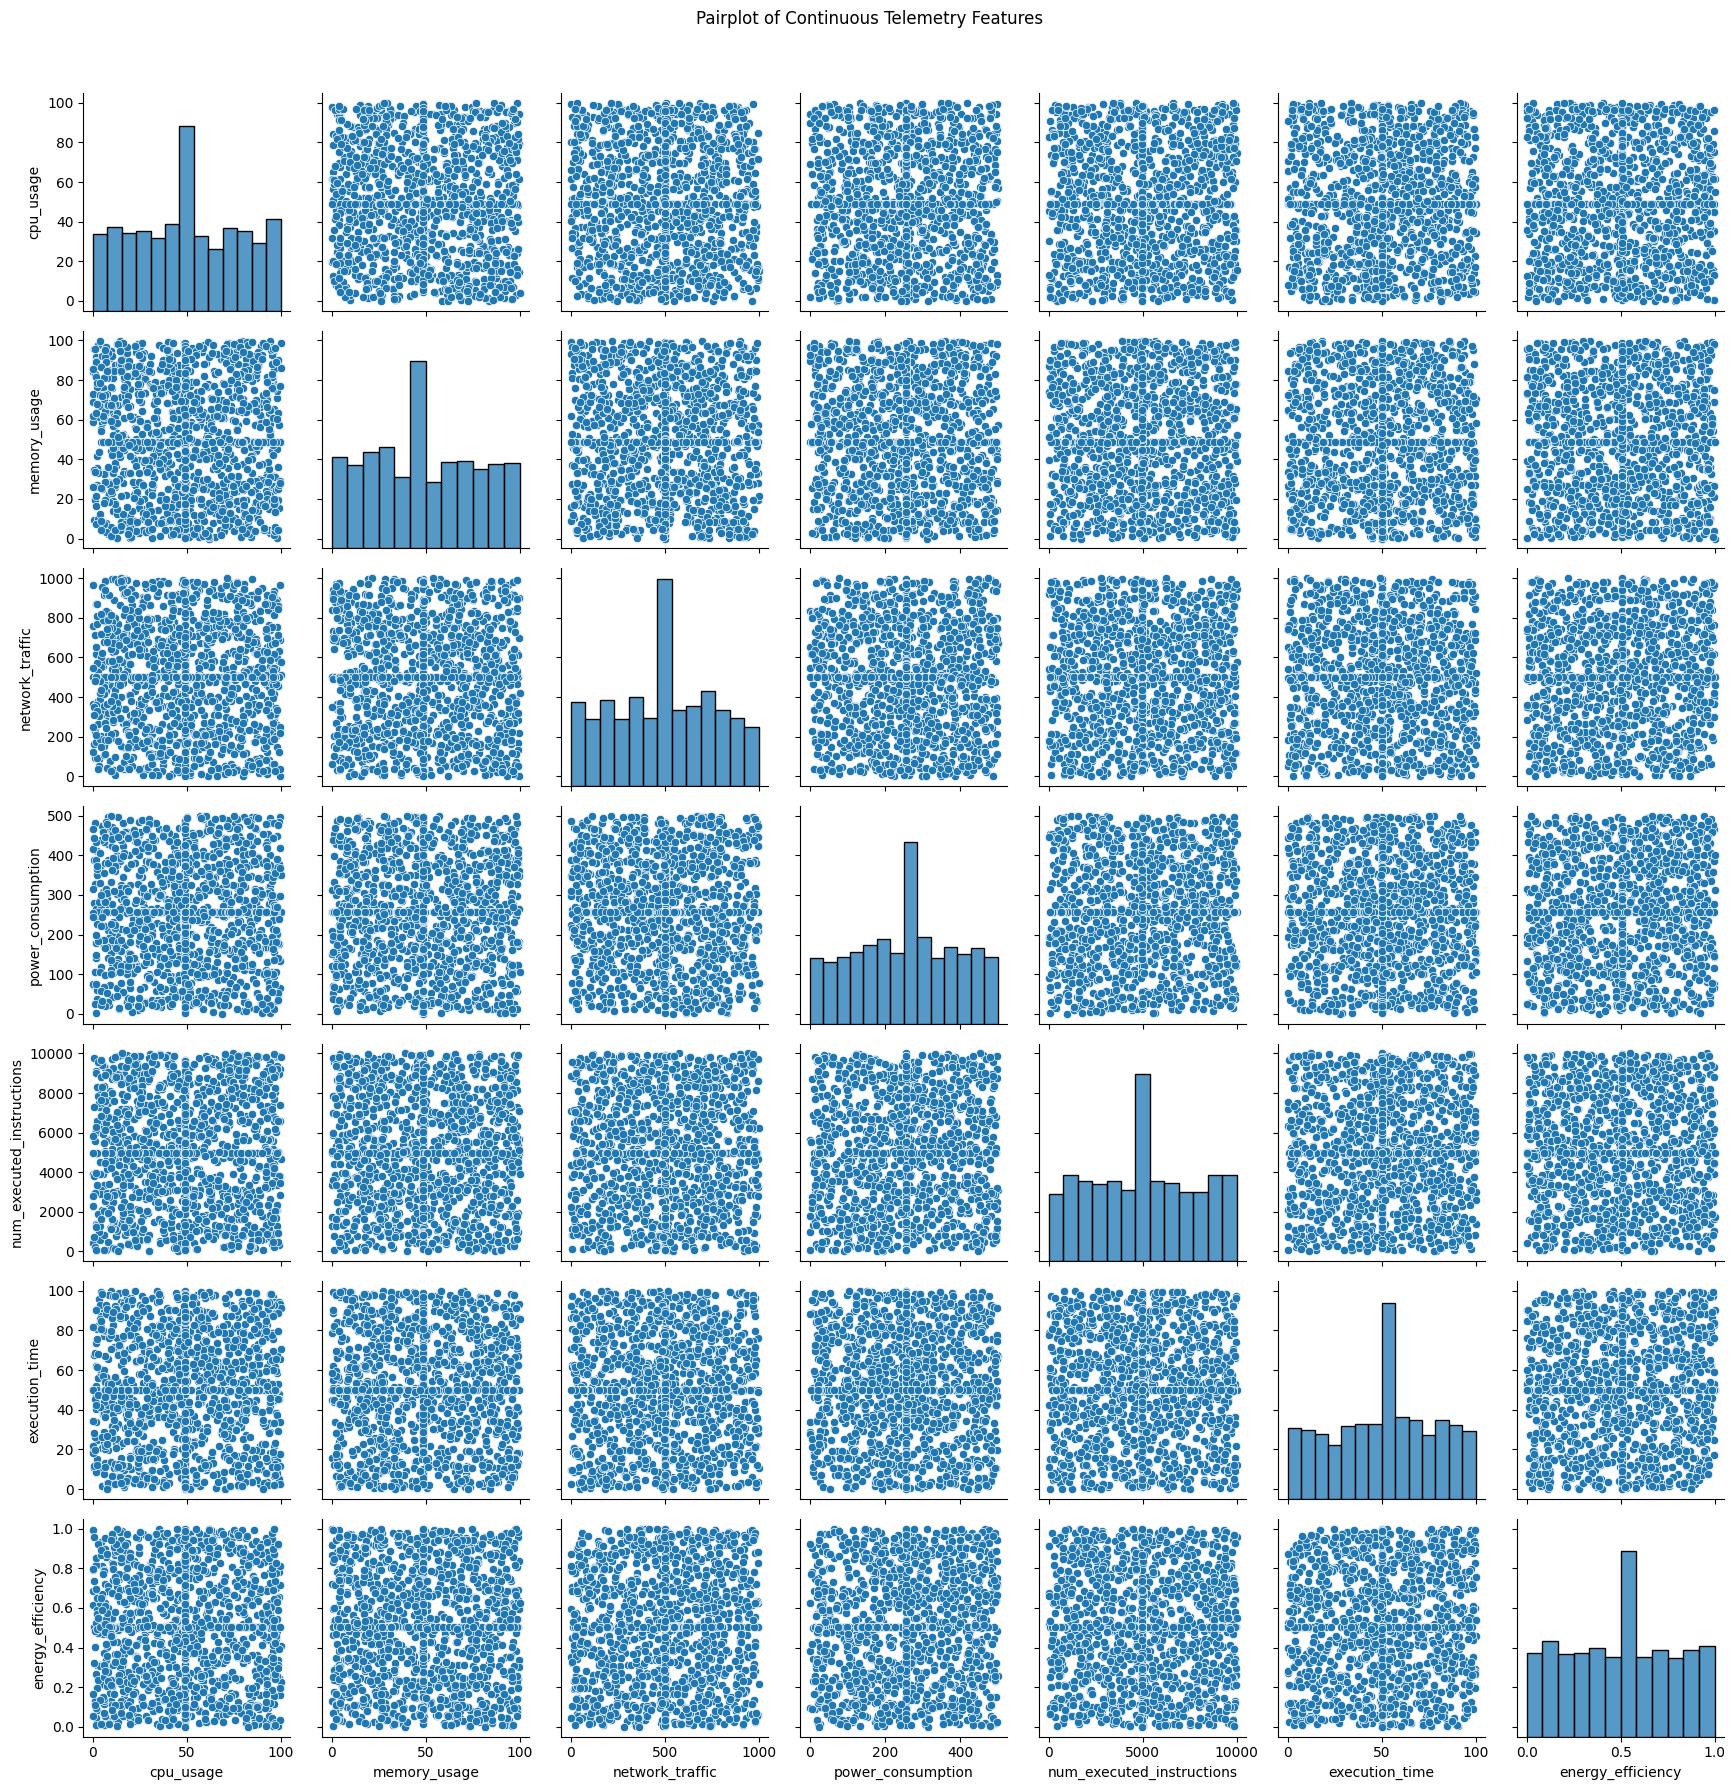

In [18]:
# Generate pairplot for continuous features
sns.pairplot(train_df[continuous_features])
plt.suptitle("Pairplot of Continuous Telemetry Features", y=1.02)
plt.tight_layout()
plt.show()

### Observation
- Lack of Strong Correlation
  - The scatter plots for most variable pairs appear uniformly spread without obvious linear or curved patterns.
  - This suggests low or no linear correlation among the continuous features.
- Uniform/Flat Distributions
  - The diagonal KDE (kernel density estimate) plots are quite flat or symmetric, aligning with previous findings that these features are approximately uniformly distributed.
  - This reinforces that the features are not skewed, which is favorable for algorithms like Isolation Forest or k-means.
- Independence
  - The apparent randomness in the scatter plots between features implies low feature redundancy — meaning each feature may contribute unique information.
  - Good for unsupervised models, which often assume independent features to detect anomalies effectively.

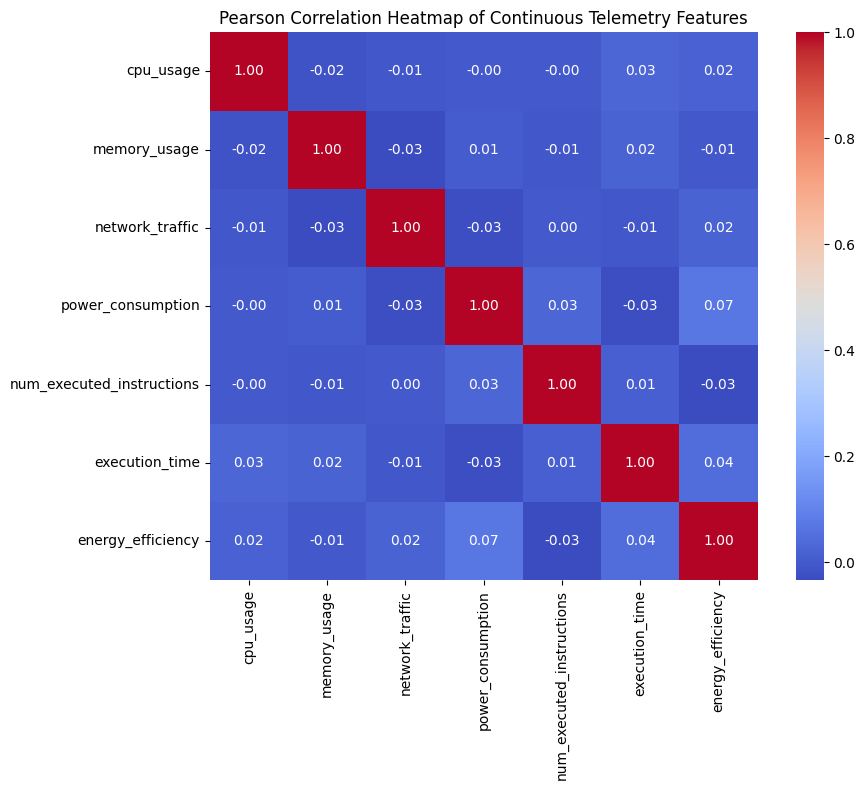

In [19]:
# Compute correlation matrix
correlation_matrix = train_df[continuous_features].corr(method="pearson")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Pearson Correlation Heatmap of Continuous Telemetry Features")
plt.tight_layout()
plt.show()

### Observation
- Very Weak or No Linear Correlation
  - All correlation values between different telemetry features fall in the range of -0.03 to +0.05, which indicates:
    - Negligible linear relationships among features.
    - For example:
      - cpu_usage and memory_usage: -0.02
      - network_traffic and execution_time: -0.03
      - power_consumption and energy_efficiency: +0.05 (still weak)
   - No feature pair shows a strong or even moderate linear dependency.
- Feature elimination unnecessary due to multicollinearity — because it’s practically absent.
- Unsupervised models such as clustering (e.g., k-Means, DBSCAN) or dimensionality reduction (e.g., PCA, t-SNE) can be explored without worrying about correlated inputs.

### Conclusion
- You could still standardize the data for scale-sensitive algorithms.
- Consider examining non-linear relationships via other techniques (e.g., mutual information, kernel PCA) if needed.

In [20]:
# # Data Splitting
# train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)

# print("Training shape:", train_df.shape)
# print("Test shape:", test_df.shape)

In [21]:
scaler = StandardScaler()
numeric_cols = train_df.select_dtypes(include=["float64", "int64", "bool"]).columns

train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

# Objective 3: Develop and evaluate an ML model (supervised or unsupervised)

In [22]:
# Evaluate anomaly scores
def evaluate_unsupervised_model(
    model, X_train: pd.DataFrame, X_eval: pd.DataFrame, split_name: str = "Validation"
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Fit an unsupervised anomaly detection model and evaluate on given data.

    Args:
        model: Unsupervised model instance with fit/predict/decision_function methods.
        X_train (pd.DataFrame): Training data used for fitting the model.
        X_eval (pd.DataFrame): Evaluation data for anomaly detection.
        split_name (str): Label for the dataset split (e.g., 'Validation' or 'Test').

    Returns:
        Tuple[np.ndarray, np.ndarray]: Binary anomaly labels and raw anomaly scores.
    """
    model_name = type(model).__name__

    # Fit the model on training data
    model.fit(X_train)

    # Special case handling for LOF
    if model_name == "LocalOutlierFactor" and not getattr(model, "novelty", False):
        raise ValueError("LOF must be initialized with novelty=True to support predict on new data.")

    # Predict anomalies
    predictions = model.predict(X_eval)
    anomalies = (predictions == -1).astype(int)
    scores = model.decision_function(X_eval)

    # Plot score distribution
    plt.figure(figsize=(10, 4))
    plt.hist(scores, bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{model_name} - {split_name} Anomaly Score Distribution")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return anomalies, scores

In [23]:
# Plot score distribution
def plot_anomaly_score_distribution(scores, model_name: str, dataset_type: str):
    """
    Plot the distribution of anomaly scores for a given model and dataset.

    This function visualizes the anomaly scores (e.g., from Isolation Forest or other
    anomaly detection models) as a histogram, helping to interpret how the model scores
    the input data in terms of "normal" vs "anomalous" behavior.

    Parameters:
        scores (array-like): A list or NumPy array of anomaly scores produced by the model.
        model_name (str): The name of the anomaly detection model (e.g., "IsolationForest").
        dataset_type (str): A label indicating the dataset type (e.g., "Train", "Test").

    Returns:
        None. Displays a histogram plot.
    """    
    plt.figure(figsize=(10, 4))
    plt.hist(scores, bins=50, alpha=0.7, edgecolor="black")
    plt.title(f"{model_name} - {dataset_type} Anomaly Score Distribution")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
# Select numeric columns for training and align val/test sets
X_train = train_df.select_dtypes(include=['float64', 'int64', 'bool'])
X_val = val_df[X_train.columns]
X_test = test_df[X_train.columns]

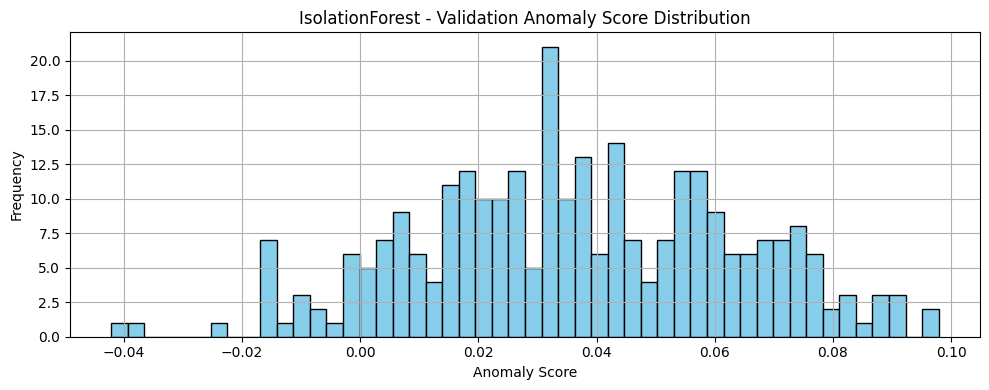

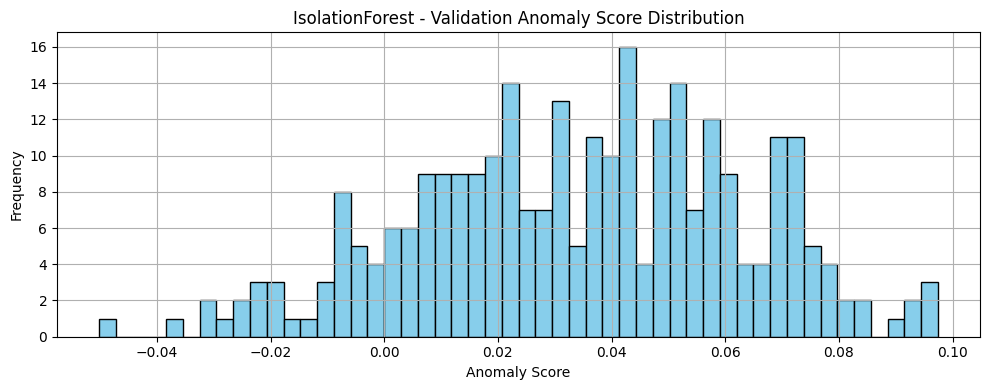

In [25]:
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

val_anomalies, val_scores = evaluate_unsupervised_model(model, X_train, X_val)
test_anomalies, test_scores = evaluate_unsupervised_model(model, X_train, X_test)


### Observation (Isolation Forest)
- Model Generalization: Demonstrates consistent behavior between validation and test sets, indicating strong generalization to unseen data.
- Distribution Stability: No significant distributional shift observed; anomaly score ranges and patterns are aligned.
- Deployment Readiness: Stable scoring pattern makes Isolation Forest well-suited for real-time anomaly detection in live telemetry settings.

c:\ChenKhoon\JupyterNotebook\edge-telemetry-anomaly-detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\ChenKhoon\JupyterNotebook\edge-telemetry-anomaly-detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


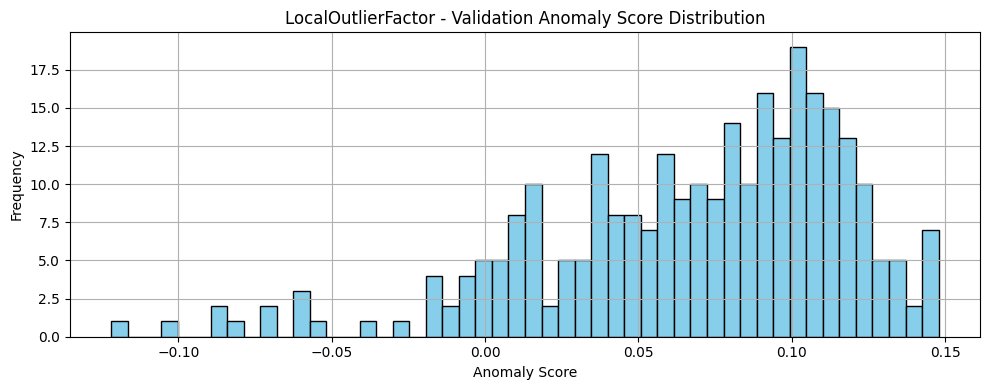

c:\ChenKhoon\JupyterNotebook\edge-telemetry-anomaly-detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\ChenKhoon\JupyterNotebook\edge-telemetry-anomaly-detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


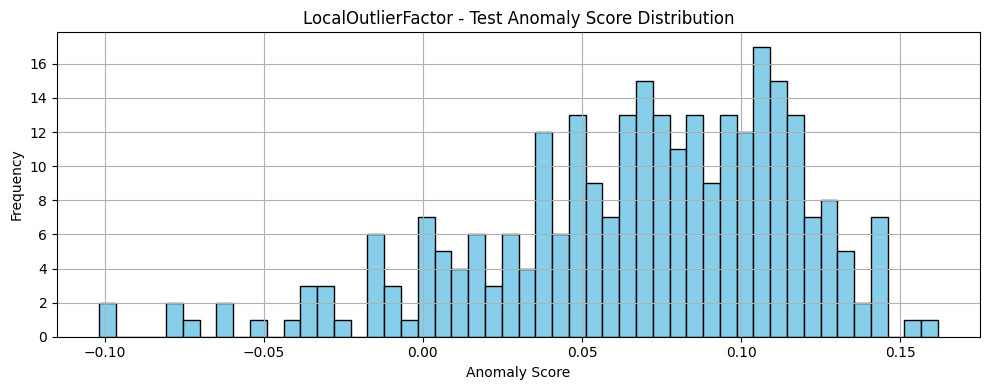

In [26]:
# Define LOF model with novelty=True for prediction on new data
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)

val_anomalies, val_scores = evaluate_unsupervised_model(lof_model, X_train, X_val, split_name="Validation")
test_anomalies, test_scores = evaluate_unsupervised_model(lof_model, X_train, X_test, split_name="Test")

### Observation (Local Outlier Factor)
- Model Generalization: Good generalization; test set behavior closely mirrors that of the validation set, with no signs of overfitting.
- Outlier Sensitivity: Slight tail differences suggest LOF identified more borderline anomalies in validation — a known sensitivity trait of LOF.
- Use Case Fit: Ideal for offline or batch anomaly analysis, where interpretability of local density deviations is valuable.

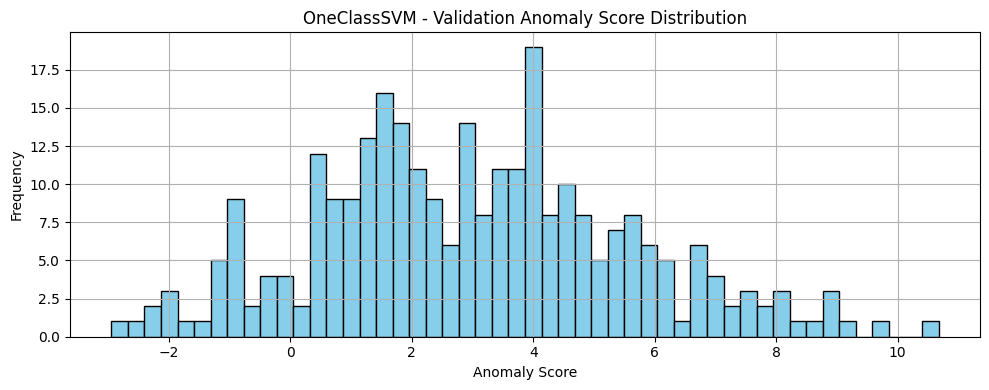

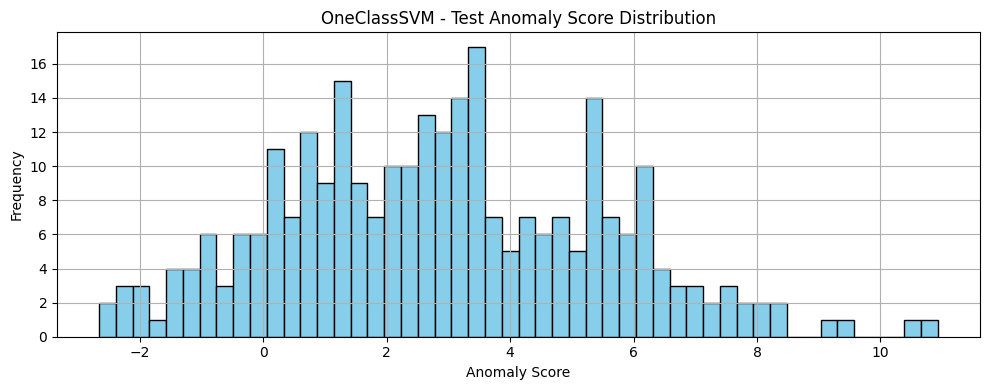

In [27]:
ocsvm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)

val_anomalies, val_scores = evaluate_unsupervised_model(ocsvm_model, X_train, X_val, split_name="Validation")
test_anomalies, test_scores = evaluate_unsupervised_model(ocsvm_model, X_train, X_test, split_name="Test")


### Observation (One-Class SVM)
- Performs consistently across validation and test sets, indicating reliable generalization.
- Smooth and right-skewed anomaly score patterns show the model is not erratic or overfitted.
- After scaling, One-Class SVM is suitable for live deployments with streaming telemetry

### Model Selection (Isolation Forest)
- Validation and test score distributions are very similar — indicating no overfitting.
- No feature scaling needed: Simpler deployment !pipeline.
- Stable behavior: Low variance in score distributions.
- Suited for real-time: Designed for high-throughput environments like streaming telemetry.

 # Objective 4: Optimize for edge deployment (compression, pruning, etc.)

In [28]:
def objective(trial: optuna.trial.Trial) -> float:
    """
    Objective function for Optuna hyperparameter tuning of Isolation Forest.

    Args:
        trial (optuna.trial.Trial): A single trial object from Optuna.

    Returns:
        float: Negative mean anomaly score on the validation set.
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_samples": trial.suggest_float("max_samples", 0.3, 1.0),
        "max_features": trial.suggest_float("max_features", 0.3, 1.0),
        "random_state": 42
    }

    model = IsolationForest(**params)

    start = time.perf_counter()
    model.fit(X_train)
    inference_duration = time.perf_counter() - start

    val_scores = model.decision_function(X_val)
    score = -np.mean(val_scores)

    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        mlflow.log_metric("validation_score", score)
        mlflow.log_metric("fit_duration", inference_duration)

        trial_model_path  = f"../model/model_trial_{trial.number}.pkl"
        joblib.dump(model, trial_model_path, compress=3)
        mlflow.log_artifact(trial_model_path)

        # ✅ Remove model file after logging
        if os.path.exists(trial_model_path):
            os.remove(trial_model_path)
    return score

In [29]:
# Run optimization
mlflow.set_tracking_uri(f"file:///{os.path.abspath('../mlruns').replace(os.sep, '/')}")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get best parameters
best_params = study.best_trial.params
best_params["random_state"] = 42
optimized_model = IsolationForest(**best_params)
_ = optimized_model.fit(X_train)


[I 2025-06-26 17:49:26,297] A new study created in memory with name: no-name-31160a4d-5af9-40af-bd5c-dbfbb0e4cf63
[I 2025-06-26 17:49:27,357] Trial 0 finished with value: 0.014034615061246052 and parameters: {'n_estimators': 60, 'max_samples': 0.859225102247837, 'max_features': 0.85462518777074}. Best is trial 0 with value: 0.014034615061246052.
[I 2025-06-26 17:49:27,856] Trial 1 finished with value: 0.015682653523619482 and parameters: {'n_estimators': 21, 'max_samples': 0.7907150700519822, 'max_features': 0.3439495954388116}. Best is trial 0 with value: 0.014034615061246052.
[I 2025-06-26 17:49:28,424] Trial 2 finished with value: 0.015488214195530932 and parameters: {'n_estimators': 11, 'max_samples': 0.48838798406876455, 'max_features': 0.7693422825490674}. Best is trial 0 with value: 0.014034615061246052.
[I 2025-06-26 17:49:29,300] Trial 3 finished with value: 0.013362578332635837 and parameters: {'n_estimators': 97, 'max_samples': 0.9867454856667954, 'max_features': 0.526119411

In [30]:
# Final evaluation and logging
os.makedirs(os.path.dirname(isolation_model_path), exist_ok=True)
with mlflow.start_run(run_name="IsolationForest_Optuna_Final"):
    # Log best hyperparameters
    mlflow.log_params(best_params)

    # Inference and timing
    start_time = time.perf_counter()
    val_preds = optimized_model.predict(X_val)
    inference_time_ms = (time.perf_counter() - start_time) * 1000
    mlflow.log_metric("inference_time_ms", inference_time_ms)
    print(f"Inference time: {inference_time_ms / 1000:.6f} seconds")

    # Convert predictions to binary anomaly labels
    val_anomalies = (val_preds == -1).astype(int)

    # Estimate memory usage using pickle (in-memory model size)
    try:
        model_bytes = pickle.dumps(optimized_model)
        model_memory_kb = len(model_bytes) / 1024
        mlflow.log_metric("model_memory_kb", model_memory_kb)
        print(f"Model memory (KB): {model_memory_kb:.2f}")
    except Exception as e:
        print(f"❌ Error estimating model size: {e}")

    # Save and log model with compression
    try:
        joblib.dump(optimized_model, isolation_model_path, compress=3)
        mlflow.log_artifact(isolation_model_path)
        print("✅ Model saved and logged with MLflow.")
    except Exception as e:
        print(f"❌ Error saving/logging model: {e}")

Inference time: 0.022992 seconds
Model memory (KB): 4040.73
✅ Model saved and logged with MLflow.


# Objective 5. Conversion of Model to ONNX

### Note on ONNX Conversion for Isolation Forest

The `IsolationForest` model from `scikit-learn` cannot be directly converted to ONNX, as ONNX does not officially support anomaly detection models like Isolation Forest. Attempts to convert via `Hummingbird` or `skl2onnx` result in missing backend errors or runtime failures due to unsupported operators.

#### Workaround

To enable ONNX-based inference, we use the following approach:
1. Train an `IsolationForest` model to label training data (`-1` for anomalies, `1` for normal).
2. Use those labels to train a `RandomForestClassifier`, which is ONNX-compatible.
3. Convert the `RandomForestClassifier` to ONNX using `skl2onnx`.
4. Run inference using `onnxruntime`.

This approach simulates anomaly detection using a supervised model that mimics the behavior of Isolation Forest while enabling fast and portable ONNX inference.


In [31]:
# Generate labels using IsolationForest
isolation_model = IsolationForest(contamination=0.1, random_state=42)
isolation_model.fit(X_train)

# Use it to label data: -1 = anomaly, 1 = normal
y_train = isolation_model.predict(X_train)
y_val = isolation_model.predict(X_val)
y_test = isolation_model.predict(X_test)


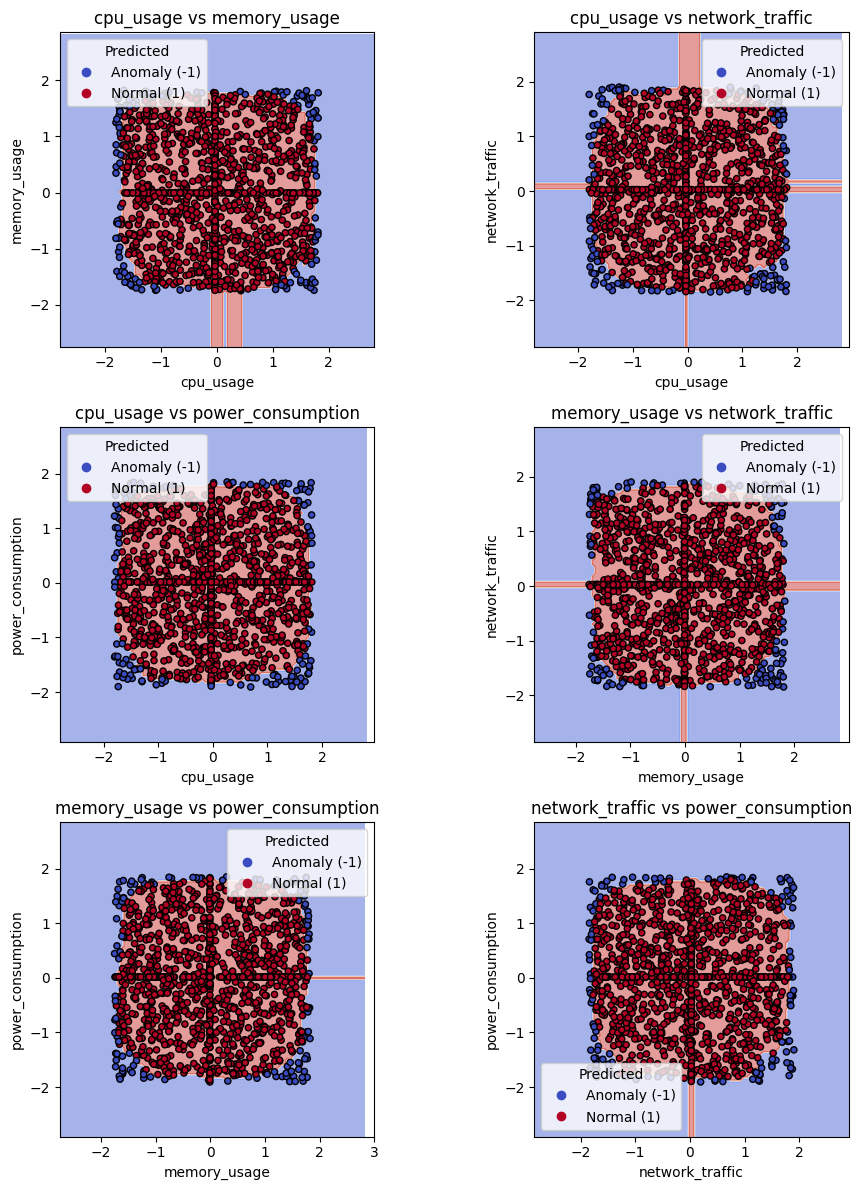

In [32]:
# Only first 4 features
feature_indices = list(range(min(4, X_train.shape[1])))
pairs = list(combinations(feature_indices, 2))
n_plots = len(pairs)

# Determine subplot grid shape
n_cols = 2
n_rows = (n_plots + 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axs = axs.flatten()

for idx, (i, j) in enumerate(pairs):
    X_pair = X_train.iloc[:, [i, j]]
    ax = axs[idx]

    # Fit Isolation Forest on 2D subset
    iso_model_2d = IsolationForest(contamination=0.1, random_state=42)
    iso_model_2d.fit(X_pair)
    y_pred_2d = iso_model_2d.predict(X_pair)

    # Plot decision boundary
    disp = DecisionBoundaryDisplay.from_estimator(
        iso_model_2d,
        X_pair,
        response_method="predict",
        alpha=0.5,
        cmap="coolwarm",
        ax=ax
    )

    scatter = ax.scatter(
        X_pair.iloc[:, 0],
        X_pair.iloc[:, 1],
        c=y_pred_2d,
        s=20,
        edgecolor="k",
        cmap="coolwarm"
    )

    ax.set_title(f"{X_train.columns[i]} vs {X_train.columns[j]}")
    ax.set_xlabel(X_train.columns[i])
    ax.set_ylabel(X_train.columns[j])
    ax.axis("square")

    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=["Anomaly (-1)", "Normal (1)"], title="Predicted")

# Hide unused subplots if any
for ax in axs[len(pairs):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

## Observation
- Anomaly clustering around boundaries:
  - In all scatter plots, anomalies (blue points) tend to cluster near the edges of the feature distributions. This aligns with Isolation Forest's behavior, which flags points in low-density regions (far from the "core" of data) as outliers.

  

In [33]:
# Train on same features using IF-generated labels
clf = RandomForestClassifier(n_estimators=100, random_state=42)
_ = clf.fit(X_train, y_train)

_ = joblib.dump(clf, random_forest_path, compress=3)

In [34]:
# Convert RandomForestClassifier to ONNX
# Define input type for ONNX
initial_type = [('input', FloatTensorType([None, X_train.shape[1]]))]

# Convert to ONNX
onnx_model = convert_sklearn(clf, initial_types=initial_type)

# Save ONNX model
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

# Objective 6. Demonstrate real-time inference and low resource usage on a PC

In [35]:
def evaluate_model_sklearn(model_path: str, input_data: np.ndarray) -> None:
    """
    Evaluate a scikit-learn model by measuring its file size and average inference time per sample.

    This function loads a scikit-learn model from the specified path and performs simulated
    single-sample inference over the input data. It prints the model file size in kilobytes
    and the average inference time per sample.

    Parameters:
        model_path (str): Path to the scikit-learn model file (.pkl).
        input_data (np.ndarray): Input data to simulate inference on.
                                 Must be 2D and of shape (n_samples, n_features).

    Returns:
        None
    """
    # Load model and measure file size
    model = joblib.load(model_path)
    model_size_kb = os.path.getsize(model_path) / 1024
    print(f"Model file size: {model_size_kb:.2f} KB")

    # Inference timing with warning suppression
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        start_time = time.time()
        for i in range(len(input_data)):
            _ = model.predict(input_data[i:i+1])
        end_time = time.time()

    avg_time = (end_time - start_time) / len(input_data)
    print(f"Avg inference time: {avg_time:.6f} seconds/sample")
    print("Model loaded and executed without GPU acceleration")

In [36]:
def evaluate_model_onnx(onnx_model_path: str, input_data: np.ndarray) -> None:
    """
    Evaluate an ONNX model's file size and average single-sample inference time.

    This function loads an ONNX model from the specified file path, runs inference on each 
    row of the input data one at a time (simulating a streaming or real-time scenario), 
    and prints:
      - The model's file size in kilobytes (KB)
      - The average inference time per sample in seconds

    It assumes the input data is a 2D NumPy array with shape (n_samples, n_features),
    and will cast each input sample to float32 as required by ONNX Runtime.

    Parameters:
        onnx_model_path (str): Path to the ONNX model file (.onnx).
        input_data (np.ndarray): Input data for inference, shape (n_samples, n_features).

    Returns:
        None
    """
    # File size
    model_size_kb = os.path.getsize(onnx_model_path) / 1024
    print(f"Model file size: {model_size_kb:.2f} KB")

    # Inference session
    session = ort.InferenceSession(onnx_model_path)
    input_name = session.get_inputs()[0].name

    # Timing inference
    start_time = time.time()
    for i in range(len(input_data)):
        sample = input_data[i:i+1].astype(np.float32)
        _ = session.run(None, {input_name: sample})
    end_time = time.time()

    avg_time = (end_time - start_time) / len(input_data)
    print(f"Avg inference time: {avg_time:.6f} seconds/sample")
    print("Model loaded and executed without GPU acceleration")

In [37]:
# Simulate a batch of 1000 test samples by repeating the available test set.
# This helps in measuring average inference time over a larger sample size.
simulated_input = np.tile(X_test.values, (1000 // len(X_test) + 1, 1))[:1000]

# Evaluate the Isolation Forest model (unsupervised anomaly detection).
print("Evaluation of Isolation Forest model")
evaluate_model_sklearn(isolation_model_path, simulated_input)

# Evaluate the Random Forest model trained using pseudo-labels (supervised proxy).
print("\nEvaluation of Random Forest model")
evaluate_model_sklearn(random_forest_path, simulated_input)

# Evaluate the ONNX-optimized version of the Random Forest model (for deployment).
print("\nEvaluation of Onnx model")
evaluate_model_onnx(onnx_model_path, simulated_input)

Evaluation of Isolation Forest model
Model file size: 1133.13 KB
Avg inference time: 0.003170 seconds/sample
Model loaded and executed without GPU acceleration

Evaluation of Random Forest model
Model file size: 277.72 KB
Avg inference time: 0.002979 seconds/sample
Model loaded and executed without GPU acceleration

Evaluation of Onnx model
Model file size: 613.42 KB
Avg inference time: 0.000054 seconds/sample
Model loaded and executed without GPU acceleration


## Observations
- The ONNX model is ~1.1× smaller than the IsolationForest model and ~2.2× larger than the RandomForestClassifier model.
- Despite its intermediate size, the ONNX model delivers a ~39× faster inference than IsolationForest, and ~70× faster than RandomForestClassifier, without GPU acceleration.
- This underscores the efficiency of ONNX Runtime, making it a strong candidate for low-latency, resource-constrained edge deployments.
- The ONNX model was derived from a supervised proxy (RandomForestClassifier) trained on pseudo-labels generated by IsolationForest, enabling exportability while preserving anomaly detection logic.